# Finetuning Hugging Face DistilBERT with Amazon Reviews Polarity dataset

Use the Hugging Faces transformers and datasets library with Amazon SageMaker to fine-tune a pre-trained transformer on binary text classification.

Use the pre-trained DistilBERT model with the Amazon Reviews Polarity dataset. We will then deploy the resulting model for inference using SageMaker Endpoint.


## SETUP

In [ ]:
!pip install -qq "sagemaker>=2.48.0" --upgrade
!pip install -qq torch==1.7.1 --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers==4.6.1 "datasets[s3]"
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"
!pip install -U sagemaker

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

In [7]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::964564632268:role/service-role/AmazonSageMaker-ExecutionRole-20220129T105728
sagemaker bucket: sagemaker-ap-southeast-1-964564632268
sagemaker session region: ap-southeast-1


## DATA

- Download the amazon_polarity dataset
- Data Preview


In [8]:
dataset_name = 'amazon_polarity'
train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])


Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/ac31acedf6cda6bc2aa50d448f48bbad69a3dd8efc607d2ff1a9e65c2476b4c1. Subsequent calls will reuse this data.


In [9]:
print(len(train_dataset))
print(len(test_dataset))

3600000
400000


In [10]:
# limiting the dataset size to speed up the training during the demo
train_dataset = train_dataset.shuffle().select(range(5000)) 

# limiting the dataset size to speed up the testing during the demo
test_dataset = test_dataset.shuffle().select(range(1000))

In [11]:
print(len(train_dataset))
print(len(test_dataset))

5000
1000


In [12]:
print(train_dataset.column_names)


['label', 'title', 'content']


In [13]:
train_dataset[0]

{'label': 1,
 'title': 'Soild Number 1 Book In Iraq and Afganastan',
 'content': 'Little Slow on Review.. I only get to read at Dr Appts and other type breaks in day.Worth the read and I can understand mind set of why book is popular in war zones.I would suggest it to anyone that enjoys military reading..'}

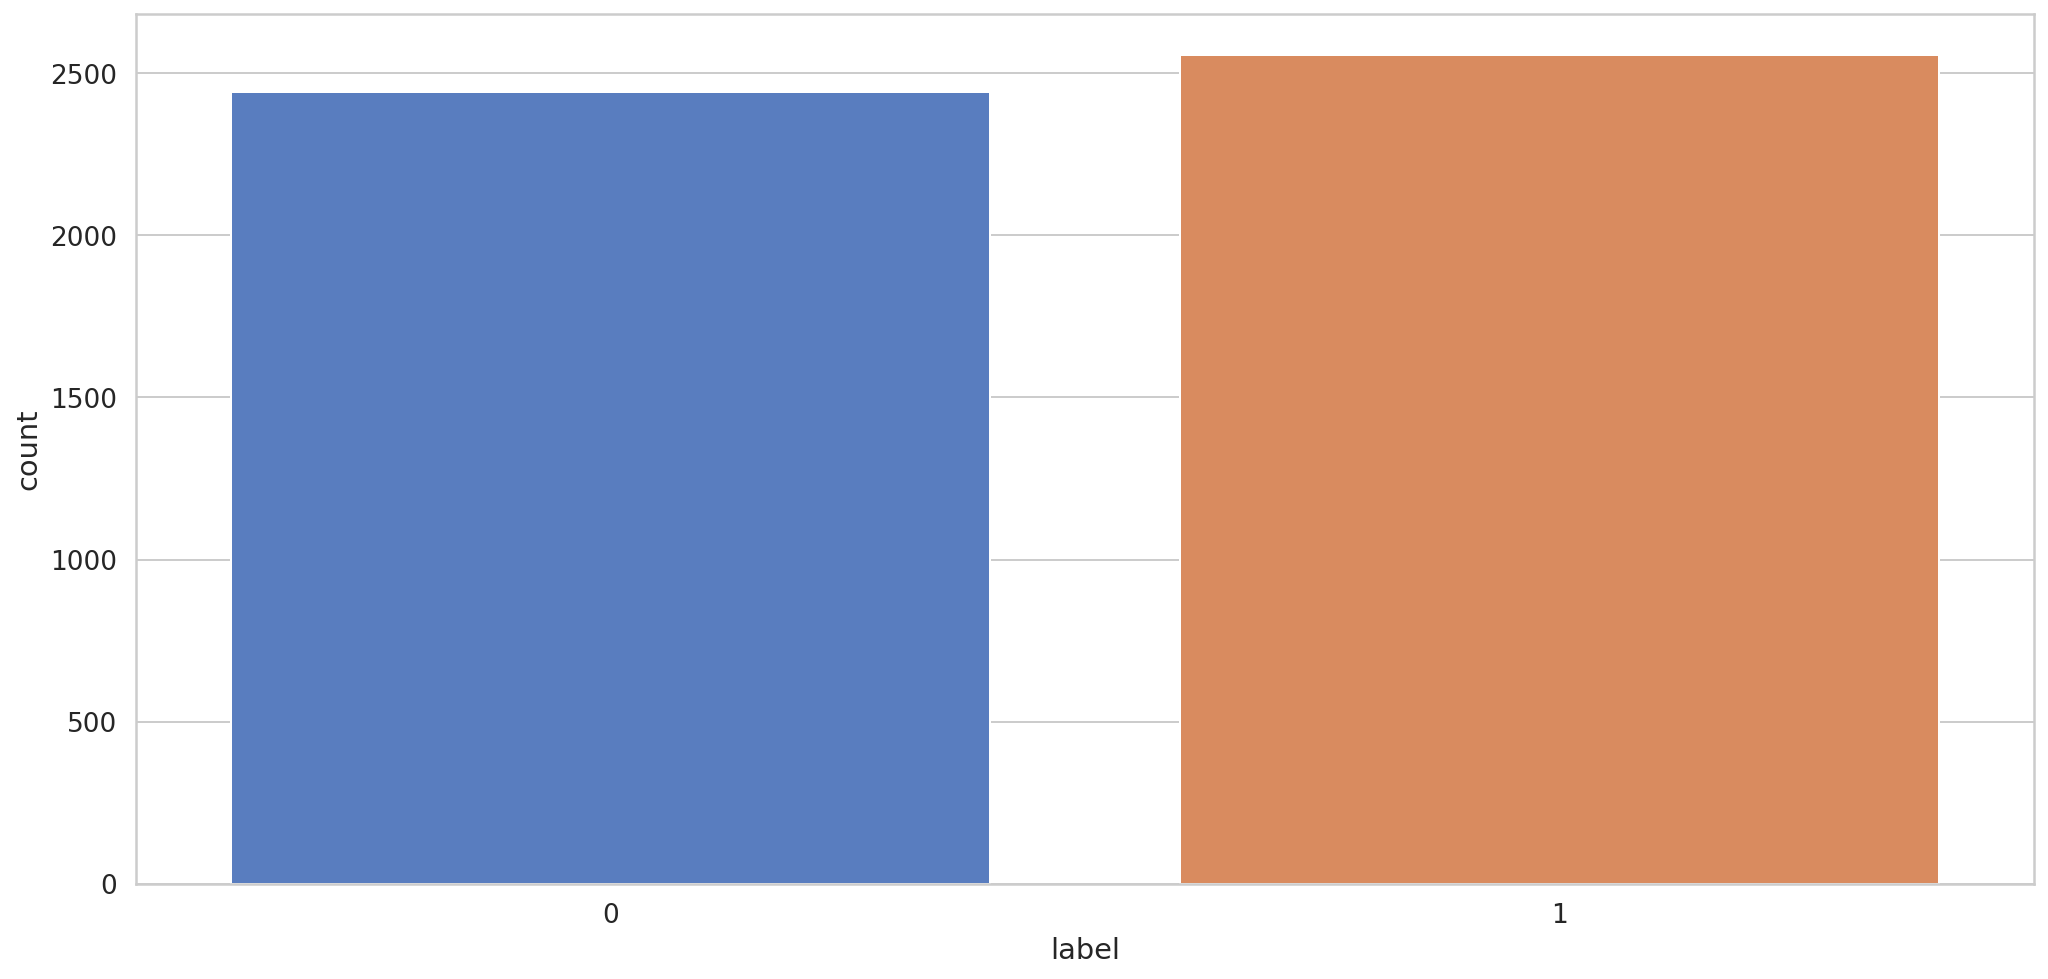

In [14]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

## Preparing the dataset to be used with PyTorch


In [15]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [16]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['content'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Uploading the data to S3


In [17]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-ap-southeast-1-964564632268/samples/datasets/amazon_polarity/train
Uploaded testing data to s3://sagemaker-ap-southeast-1-964564632268/samples/datasets/amazon_polarity/test


In [18]:
!pygmentize ./scripts/train.py


"""
Training script for Hugging Face SageMaker Estimator
"""
import logging
import sys
import argparse
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--tokenizer_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_

## Creating an Estimator and start a training job


In [19]:
model_name = 'distilbert-base-cased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-distilbert-base-cased-2022-01-30-06-28-08


In [20]:
hyperparameters={'epochs': 3,
                 'train_batch_size': 32,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
                 'output_dir':'/opt/ml/checkpoints',
                 }

In [21]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [48]:
use_spot_instances = True
max_run = 36000
max_wait = 36000 if use_spot_instances else None

huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type="ml.p3.2xlarge",
                            instance_count=1,
                            role=role,
                            transformers_version='4.6', 
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,

                            use_spot_instances=use_spot_instances,
                            max_run=max_run, # expected max run in seconds,
                            max_wait=max_wait
                        )

In [49]:
huggingface_estimator.fit(
    {
        'train': training_input_path, 
        'test': test_input_path
    }, 
    wait=False, 
    job_name=training_job_name
)

In [50]:
sess.wait_for_job(training_job_name)


2022-01-30 07:08:10 Starting - Launching requested ML instances..........
2022-01-30 07:09:17 Starting - Preparing the instances for training............................
2022-01-30 07:11:44 Downloading - Downloading input data......
2022-01-30 07:12:21 Training - Downloading the training image...................
2022-01-30 07:13:59 Training - Training image download completed. Training in progress..................................................................
2022-01-30 07:19:34 Uploading - Uploading generated training model......
2022-01-30 07:20:09 Completed - Training job completed


{'TrainingJobName': 'finetune-distilbert-base-cased-2022-01-30-06-28-08',
 'TrainingJobArn': 'arn:aws:sagemaker:ap-southeast-1:964564632268:training-job/finetune-distilbert-base-cased-2022-01-30-06-28-08',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-ap-southeast-1-964564632268/finetune-distilbert-base-cased-2022-01-30-06-28-08/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'epochs': '3',
  'model_name': '"distilbert-base-cased"',
  'output_dir': '"/opt/ml/checkpoints"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"finetune-distilbert-base-cased-2022-01-30-06-28-08"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"ap-southeast-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-1-964564632268/finetune-distilbert-base-cased-2022-01-30-06-28-08/source/sourcedir.tar.gz"',
  'tokenizer_name': '"distilbert-base-cased"',
  'train_batch_size': '32'},
 'AlgorithmSpecif

## Training metrics


In [51]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

,timestamp,metric_name,value
0,0.0,eval_loss,0.308880
1,60.0,eval_loss,0.320426
2,180.0,eval_loss,0.260939
3,0.0,eval_accuracy,0.876000
4,60.0,eval_accuracy,0.881000
5,180.0,eval_accuracy,0.904000
6,0.0,eval_f1,0.879142
7,60.0,eval_f1,0.884578
8,180.0,eval_f1,0.902637
9,0.0,eval_precision,0.835185


<AxesSubplot:label='f46fe769-8304-4d21-b478-06c2cca22efd', xlabel='timestamp', ylabel='value'>

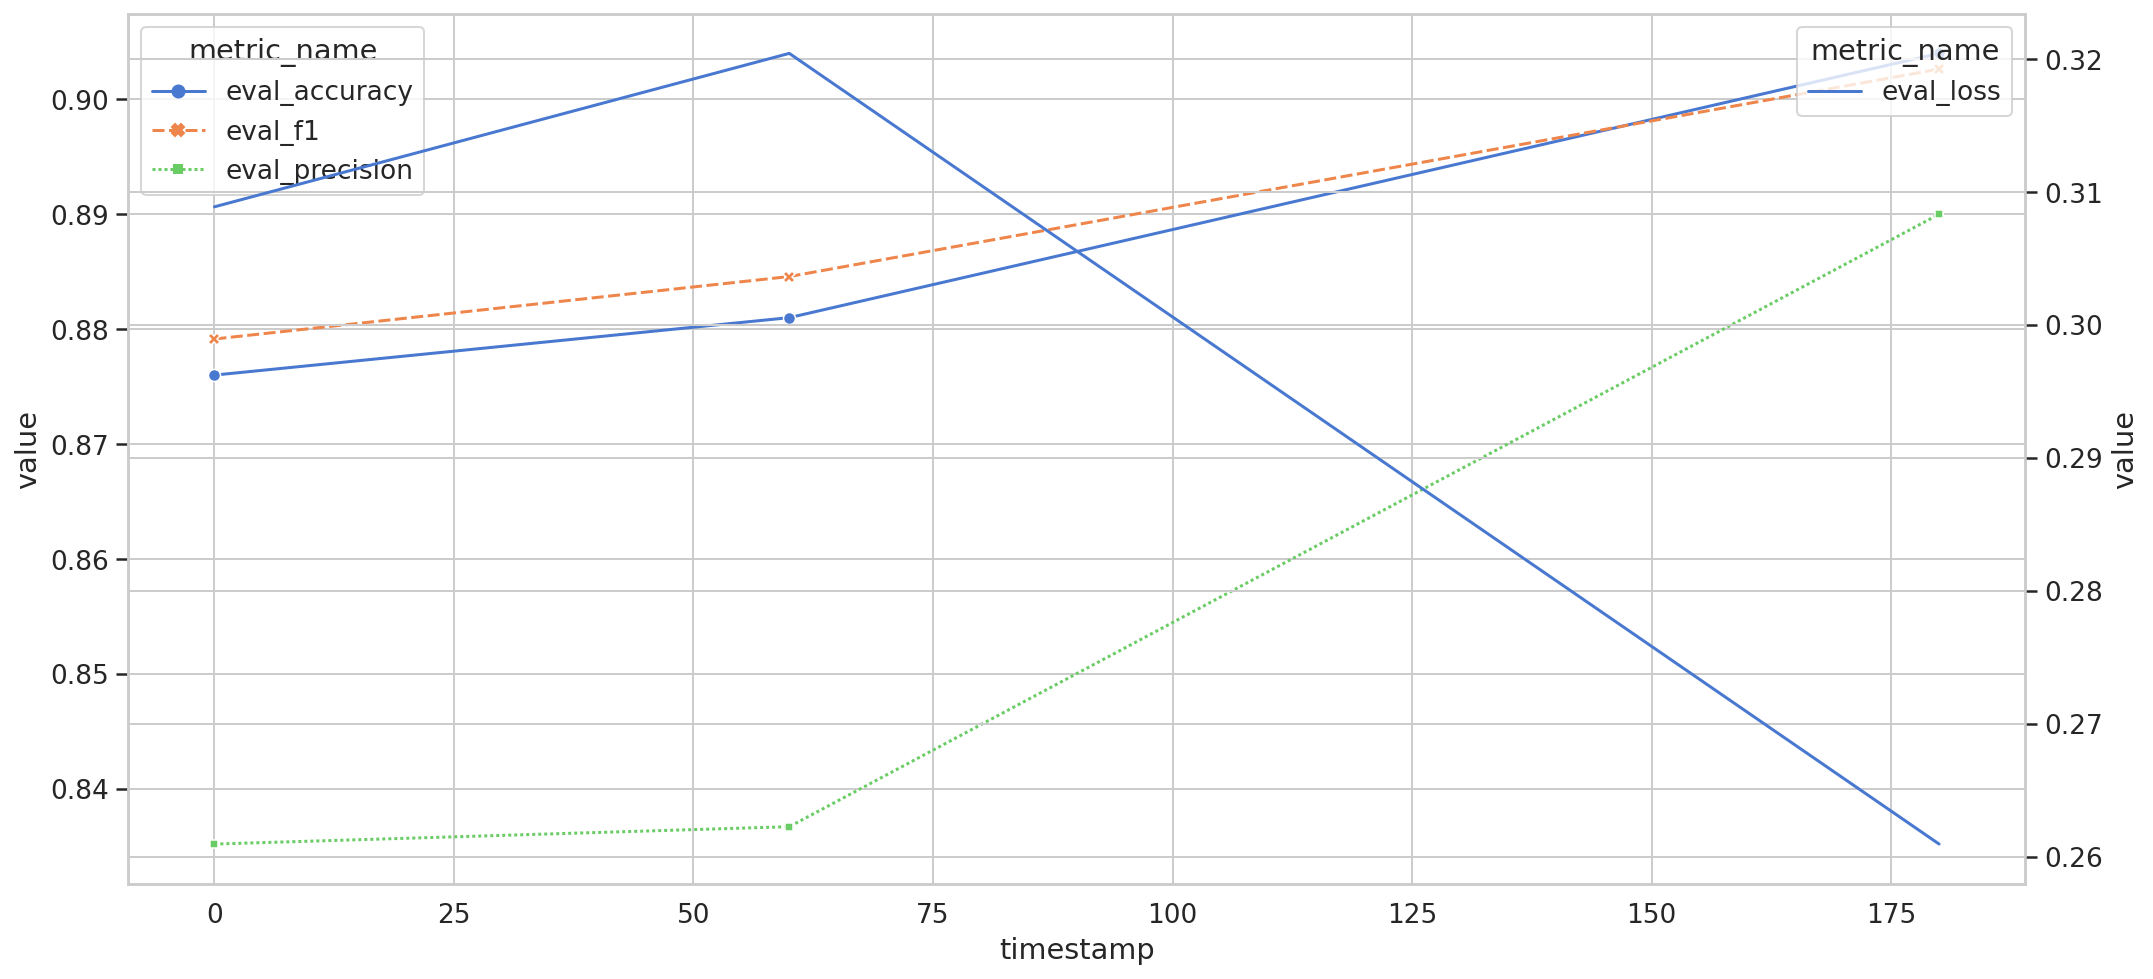

In [52]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

## Endpoint


In [53]:
predictor = huggingface_estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge", 
    endpoint_name=training_job_name
)


----!

In [54]:
data = {
   "inputs": [
       "Good product!",
       "Product is not good at all",
       "Idea is good, but product quality is poor"
   ]
}

# request
predictor.predict(data)

[{'label': 'LABEL_1', 'score': 0.9906685948371887},
 {'label': 'LABEL_0', 'score': 0.93738853931427},
 {'label': 'LABEL_0', 'score': 0.5415887832641602}]

## Cleanup


In [55]:
predictor.delete_endpoint()

## REFERENCES

1. GitHub Repository: <https://github.com/aws-samples/finetune-deploy-bert-with-amazon-sagemaker-for-hugging-face>
2. Notebook Link: <https://github.com/aws-samples/finetune-deploy-bert-with-amazon-sagemaker-for-hugging-face/blob/main/finetune-distilbert.ipynb>